In [1]:
#!pip install pandas pyodbc

In [2]:
import pandas as pd
import pyodbc
from sqlalchemy import create_engine
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
print('Import librarys successfully')

Import librarys successfully


In [3]:
# Tạo đối tượng kết nối sử dụng SQLAlchemy
conn_str = 'mssql+pyodbc://ANPHATPC/AdventureWork?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(conn_str)

# Sử dụng SQL query để đọc dữ liệu
query = '''
SELECT soh.SalesOrderID,
       sod.SalesOrderDetailID,
       sod.OrderQty,
       sod.UnitPrice,
       soh.OrderDate,
       soh.CustomerID
FROM [dbo].[FACT_SalesOrderDetail] sod 
JOIN [dbo].[FACT_SalesOrderHeader] soh 
ON sod.SalesOrderID = soh.SalesOrderID
WHERE soh.OrderMethod = 'Reseller'
'''

reseller_df = pd.read_sql(query, engine)
reseller_df.head()

,SalesOrderID,SalesOrderDetailID,OrderQty,UnitPrice,OrderDate,CustomerID
0,45266,5717,2,2024.9940,2012-01-01,29955
1,45266,5718,3,2039.9940,2012-01-01,29955
2,45266,5719,2,2024.9940,2012-01-01,29955
3,45266,5720,1,714.7043,2012-01-01,29955
4,45266,5721,2,2024.9940,2012-01-01,29955


In [4]:
# Tạo đối tượng kết nối sử dụng SQLAlchemy
conn_str = 'mssql+pyodbc://ANPHATPC/AdventureWork?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(conn_str)

# Sử dụng SQL query để đọc dữ liệu
query = '''
SELECT soh.SalesOrderID,
       sod.SalesOrderDetailID,
       sod.OrderQty,
       sod.UnitPrice,
       soh.OrderDate,
       soh.CustomerID
FROM [dbo].[FACT_SalesOrderDetail] sod 
JOIN [dbo].[FACT_SalesOrderHeader] soh 
ON sod.SalesOrderID = soh.SalesOrderID
WHERE soh.OrderMethod = 'Online'
'''

online_df = pd.read_sql(query, engine)
online_df.head()

,SalesOrderID,SalesOrderDetailID,OrderQty,UnitPrice,OrderDate,CustomerID
0,45345,6583,1,3578.2700,2012-01-01,15048
1,45346,6584,1,3578.2700,2012-01-01,28648
2,45347,6585,1,699.0982,2012-01-01,14733
3,45348,6586,1,3578.2700,2012-01-01,19562
4,45349,6587,1,3578.2700,2012-01-01,19568


In [5]:
print(f"reseller_info: {reseller_df.info()}")
print(f"online_info: {online_df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46560 entries, 0 to 46559
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SalesOrderID        46560 non-null  int64         
 1   SalesOrderDetailID  46560 non-null  int64         
 2   OrderQty            46560 non-null  int64         
 3   UnitPrice           46560 non-null  float64       
 4   OrderDate           46560 non-null  datetime64[ns]
 5   CustomerID          46560 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 2.1 MB
reseller_info: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31702 entries, 0 to 31701
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SalesOrderID        31702 non-null  int64         
 1   SalesOrderDetailID  31702 non-null  int64         
 2   OrderQty          

In [6]:
reseller_df.duplicated().sum()

0

In [7]:
online_df.duplicated().sum()

0

In [8]:
reseller_df.isnull().sum()

SalesOrderID          0
SalesOrderDetailID    0
OrderQty              0
UnitPrice             0
OrderDate             0
CustomerID            0
dtype: int64

In [9]:
online_df.isnull().sum()

SalesOrderID          0
SalesOrderDetailID    0
OrderQty              0
UnitPrice             0
OrderDate             0
CustomerID            0
dtype: int64

# Point to be noted
- Đây là dữ liệu được đọc từ Data WareHouse vì vậy dữ liệu đã được xử lý từ trước khi đọc file.

# EDA

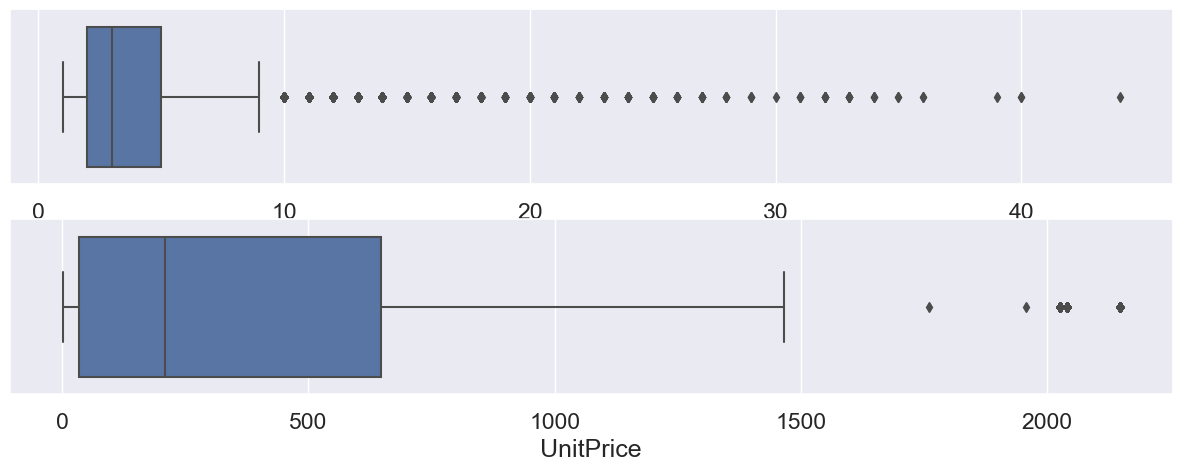

In [10]:
column = ['OrderQty', 'UnitPrice']
fig, axes = plt.subplots(2,1, figsize=(15,5))
for i, c in enumerate(column):
    sns.boxplot(reseller_df, x = c, ax= axes[i])

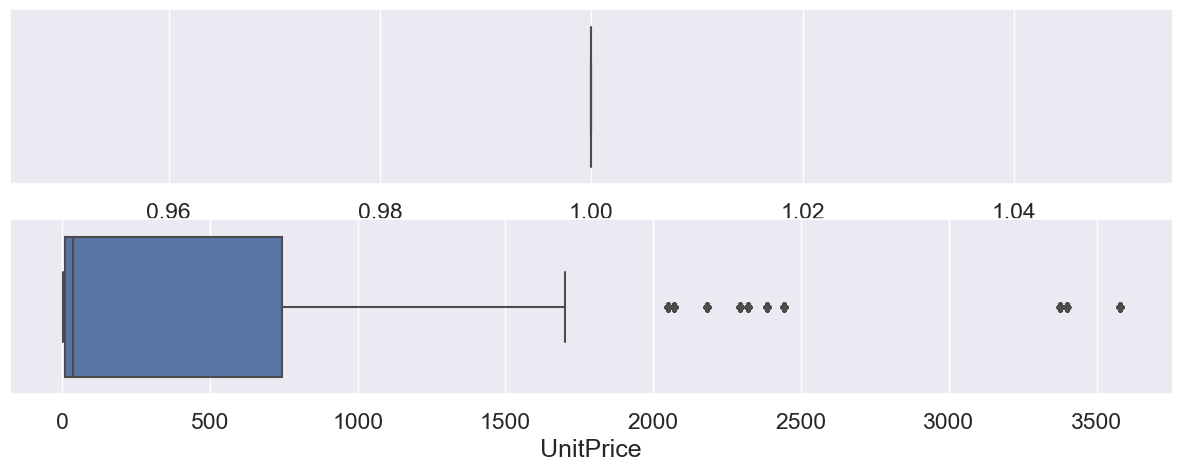

In [11]:
column = ['OrderQty', 'UnitPrice']
fig, axes = plt.subplots(2,1, figsize=(15,5))
for i, c in enumerate(column):
    sns.boxplot(online_df, x = c, ax= axes[i])

In [12]:
# Defining funtion to remove outlier
def outlier_thresholds(dataframe, variable):
    q1 = dataframe[variable].quantile(0.01)
    q3 = dataframe[variable].quantile(0.99)
    iqr = q3-q1
    low_limit = q1 - 1.5*iqr
    up_limit = q3 + 1.5*iqr
    return low_limit, up_limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    print(f"No of outlier before replace: {len(dataframe.loc[dataframe[variable] < low_limit]) + len(dataframe.loc[dataframe[variable] > up_limit])}")
    dataframe.loc[dataframe[variable] < low_limit, variable] = low_limit
    dataframe.loc[dataframe[variable] > up_limit, variable] = up_limit
    print(f"No of outlier after replace: {len(dataframe.loc[dataframe[variable] < low_limit]) + len(dataframe.loc[dataframe[variable] > up_limit])}")

In [13]:
replace_with_thresholds(online_df, 'UnitPrice')
replace_with_thresholds(online_df, 'OrderQty')

No of outlier before replace: 0
No of outlier after replace: 0
No of outlier before replace: 0
No of outlier after replace: 0


In [14]:
#Create Amount Column
reseller_df['Amount'] = reseller_df['OrderQty'] * reseller_df['UnitPrice']
online_df['Amount'] = online_df['OrderQty'] * online_df['UnitPrice']

In [15]:
#Create RFM
reference_day = reseller_df['OrderDate'].max() + pd.DateOffset(days = 1)
print(reference_day)
RFM_reseller = reseller_df.groupby('CustomerID').agg({'OrderDate' : lambda x: (reference_day - x.max()).days,
                                                      'SalesOrderID': lambda x: x.nunique(),
                                                      'Amount': lambda x: x.sum()
                                                        
                                                    })
RFM_online = online_df.groupby('CustomerID').agg({'OrderDate' : lambda x: (reference_day - x.max()).days,
                                                      'SalesOrderID': lambda x: x.nunique(),
                                                      'Amount': lambda x: x.sum()
                                                        
                                                    })
print(RFM_reseller.describe())
print(RFM_online.describe())

2014-01-01 00:00:00
        OrderDate  SalesOrderID         Amount
count  627.000000    627.000000     627.000000
mean   131.521531      4.417863   96507.528504
std    187.515343      2.398921  139572.280819
min      1.000000      1.000000       1.374000
25%      1.000000      2.000000    5292.991750
50%     63.000000      4.000000   32377.813000
75%    154.000000      7.000000  122069.000550
max    731.000000      9.000000  699234.323300
          OrderDate  SalesOrderID        Amount
count  11829.000000  11829.000000  11829.000000
mean     151.033646      1.295714   1447.521116
std      152.636614      0.751371   1755.939838
min        1.000000      1.000000      2.290000
25%       51.000000      1.000000     56.970000
50%      107.000000      1.000000    699.098200
75%      174.000000      1.000000   2407.040000
max      731.000000     20.000000  10899.620000


In [16]:
RFM_reseller.rename(columns = {'OrderDate': 'Recency',
                             'SalesOrderID': 'Frequency',
                             'Amount': 'Monetary'}, inplace = True)
RFM_online.rename(columns = {'OrderDate': 'Recency',
                             'SalesOrderID': 'Frequency',
                             'Amount': 'Monetary'}, inplace = True)
print(RFM_reseller.tail())
print(RFM_online.tail())

            Recency  Frequency     Monetary
CustomerID                                 
30114            32          7   11083.8191
30115             1          7    8245.2654
30116            32          3  148710.2730
30117             1          9  699161.4240
30118            63          6  221811.3902
            Recency  Frequency   Monetary
CustomerID                               
29479           331          1  2049.0982
29480            15          1  2442.0300
29481           719          1  3374.9900
29482           317          1  2049.0982
29483           326          1  2049.0982


In [17]:
RFM_reseller.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 29484 to 30118
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    627 non-null    int64  
 1   Frequency  627 non-null    int64  
 2   Monetary   627 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 19.6 KB


<Axes: xlabel='Recency', ylabel='Count'>

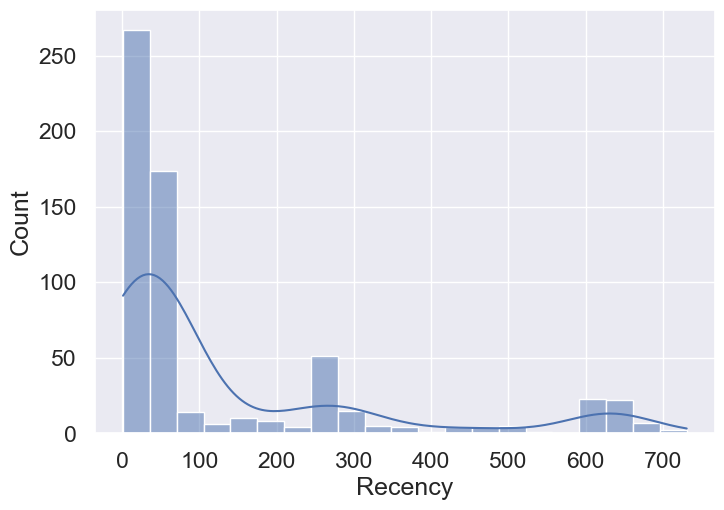

In [18]:
sns.histplot(data = RFM_reseller, x = 'Recency', kde = True)

<Axes: xlabel='Frequency', ylabel='Count'>

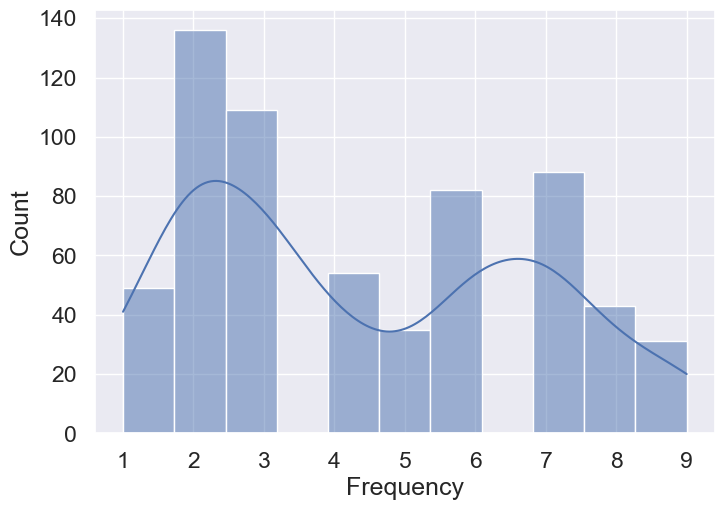

In [19]:
sns.histplot(data = RFM_reseller, x = 'Frequency', kde = True)

<Axes: xlabel='Monetary', ylabel='Count'>

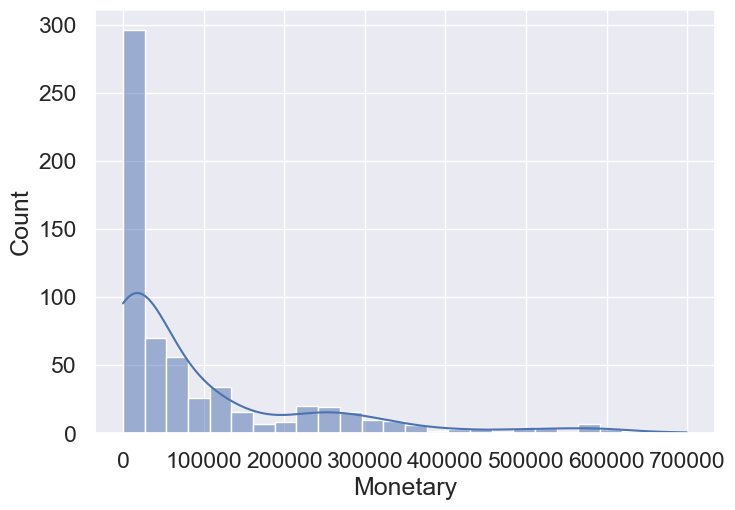

In [20]:
sns.histplot(data = RFM_reseller, x = 'Monetary', kde = True)

In [21]:
RFM_online[['Recency_log', 'Frequency_log', 'Monetary_log']] = RFM_online[['Recency', 'Frequency', 'Monetary']].applymap(lambda x: np.log(x))
scaler = StandardScaler()
scaler.fit(RFM_online[['Recency_log', 'Frequency_log', 'Monetary_log']])
scaler_data_online = scaler.transform(RFM_online[['Recency_log', 'Frequency_log', 'Monetary_log']])
scaler_data_online

RFM_reseller[['Recency_log', 'Frequency_log', 'Monetary_log']] = RFM_reseller[['Recency', 'Frequency', 'Monetary']].applymap(lambda x: np.log(x))
scaler1 = StandardScaler()
scaler1.fit(RFM_online[['Recency_log', 'Frequency_log', 'Monetary_log']])
scaler_data_reseller = scaler1.transform(RFM_reseller[['Recency_log', 'Frequency_log', 'Monetary_log']])
scaler_data_reseller

array([[ 0.87182228,  4.6987844 ,  2.79016937],
       [-0.31113299,  1.48871429,  2.42224772],
       [-0.31113299,  5.53937178,  3.31093119],
       ...,
       [-0.89939785,  2.67345566,  2.86254356],
       [-3.90910287,  5.88352577,  3.59853455],
       [-0.31113299,  4.6987844 ,  3.05265462]])

F:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
F:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
F:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
F:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

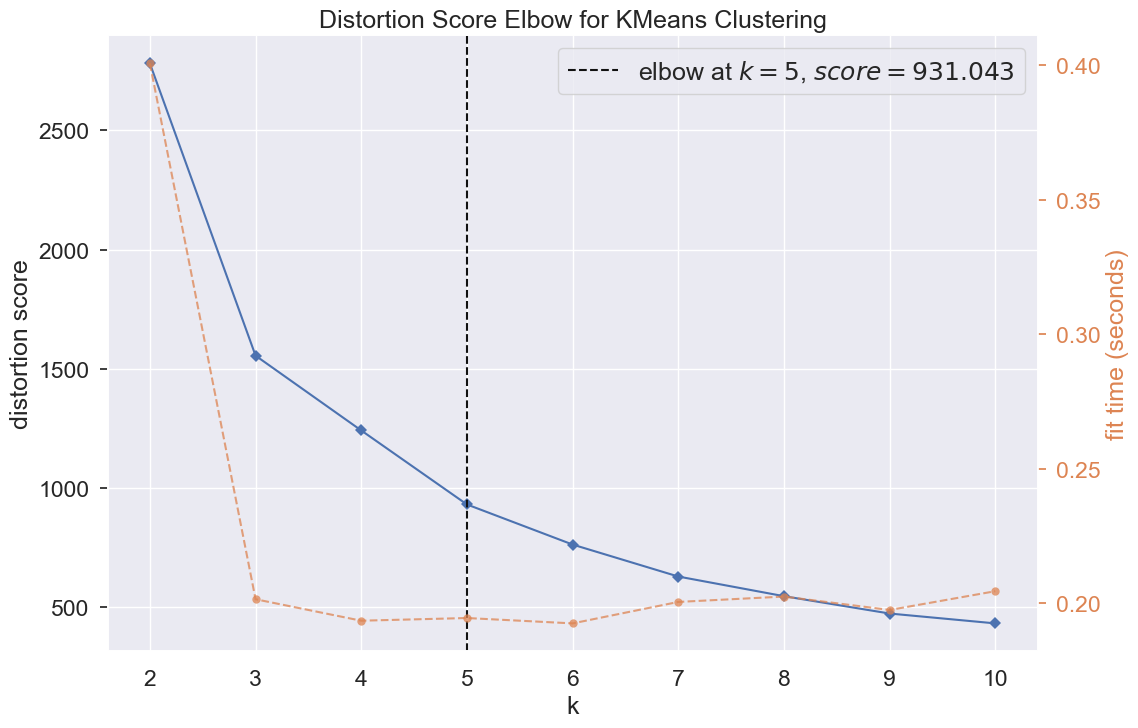

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
plt.figure(figsize=(12,8))
Elbow = KElbowVisualizer(KMeans(n_init = 10), k =10)
Elbow.fit(scaler_data_reseller)
Elbow.show()

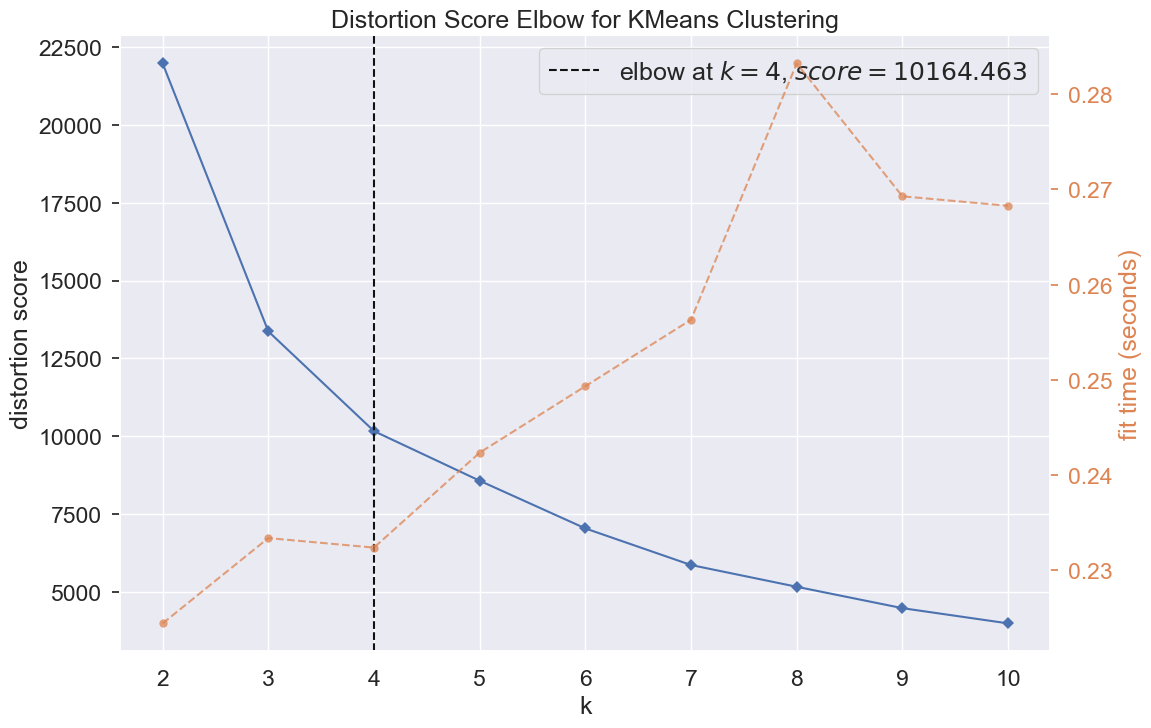

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
plt.figure(figsize=(12,8))
Elbow = KElbowVisualizer(KMeans(n_init = 10), k =10)
Elbow.fit(scaler_data_online)
Elbow.show()

In [24]:
#k = 4
model = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 1000, random_state= 2024)
model.fit_predict(scaler_data_online)

array([0, 3, 0, ..., 3, 3, 3])

In [25]:
silhouette_score(scaler_data_online, model.labels_)

0.4944122945738943